# **TracIn**: Estimating Training Data Influence by Tracing Gradient Descent


**Importing libraries**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

▶ **Method : TracIn**

> TracIn discerns the **influence** of a training data point on a prediction point, i.e. it traces the changes in the loss of
a test point throughout the training process whenever the training example of interest was utilized.


---



> TracIn draws inspiration from *the fundamental theorem of calculus*, examining the difference between the loss of the test point at the **end of training** versus at the **beginning of training** along the path taken by the training process.


---





**Dataset : CIFAR10**

In [2]:
# Loading the CIFAR10 dataset that consists of 60000 32x32 colour images in 10 classes,
# with 6000 images per class.


# Transform images into tensors and normalize them
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

batch_size = 128

# Load the train and test images
trainset_c10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader_c10 = torch.utils.data.DataLoader(trainset_c10, batch_size=batch_size,
                                          shuffle=True)

testset_c10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader_c10 = torch.utils.data.DataLoader(testset_c10, batch_size=1,
                                         shuffle=False)

# Define the 10 classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 81720379.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


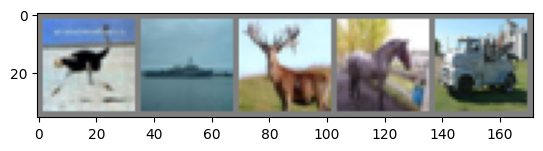

bird 		ship 		deer 		horse		truck


In [3]:
# Visualize the dataset

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
show_c10 = torch.utils.data.DataLoader(trainset_c10, batch_size=5,
                                          shuffle=True, num_workers=2)
dataiter_c10 = iter(show_c10)
images_c10, labels_c10 = next(dataiter_c10)

# Show images
imshow(torchvision.utils.make_grid(images_c10))
print('\t\t'.join(f'{classes[labels_c10[j]]:5s}' for j in range(5)))

**Image Classification :** A simple 5-layer Convolutional Neural Network. This network does not guarantee a high accuracy but is fast and for this task we prioritize speed.

In [33]:
class Net_c10(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 input image channels (RGB), 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_c = Net_c10().to(device)

**Loss Function :** Cross Entropy (Multi-class Classification)

In [6]:
criterion = nn.CrossEntropyLoss()

**Optimizer :** Stochastic Gradient Descent *(SGD)* works by iteratively updating the parameters of the neural network. At each iteration, SGD randomly selects one training example and calculates the gradient of the error function with respect to the parameters. The gradient is a vector that points in the direction of the steepest descent of the error function.

In [7]:
# SGD is ESSENTIAL here because it operates by making modifications to the model's parameters that
# locally reduce the loss with each pass, i.e. the model's parameters are changed every time a training point is visited.
# This change in the model's parameters in turn changes the loss of the prediction point and this is what our method TracIn
# is based on.

optimizer_c = optim.SGD(model_c.parameters(), lr=0.01, momentum=0.9)

In [8]:
# Initialize a weights list for saving checkpoints

weights_c = []

**Training**

In [9]:
print('Starting Training....')

checkpoint = 1

for epoch in range(1, 10):

    epoch_loss = 0
    for i, data in enumerate(trainloader_c10, 0):
        inputs, labels = data
        optimizer_c.zero_grad()
        outputs = model_c(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_c.step()

        epoch_loss += loss.item()

        if i!=0 and i % 390 == 0:
            print('[%d] loss: %.3f' %
                  (epoch, epoch_loss / 390))
            epoch_loss = 0

    # Saving checkpoints
    if epoch % 3 == 0:
        torch.save(model_c.state_dict(), f'model_checkpoint_{checkpoint}')
        weights_c.append(f'model_checkpoint_{checkpoint}')
        checkpoint += 1

print('Finished Training')

Starting Training....
[1] loss: 2.052
[2] loss: 1.550
[3] loss: 1.363
[4] loss: 1.258
[5] loss: 1.177
[6] loss: 1.121
[7] loss: 1.071
[8] loss: 1.023
[9] loss: 0.986
Finished Training


In [10]:
# 3 checkpoints

print(weights_c)

['model_checkpoint_1', 'model_checkpoint_2', 'model_checkpoint_3']


**Implementing TracInCP :**


Precisely monitoring the changes in the loss of a test point necessitates knowledge of the prediction point throughout training, which is impractical.

**-->** Hence, we employ **checkpoints** and **gradients** to estimate this influence. Essentially, we utilize the gradient of the training point's loss to gauge how it would impact the model's parameters, and the gradient of the test point's loss to estimate how the parameter changes would influence the score.



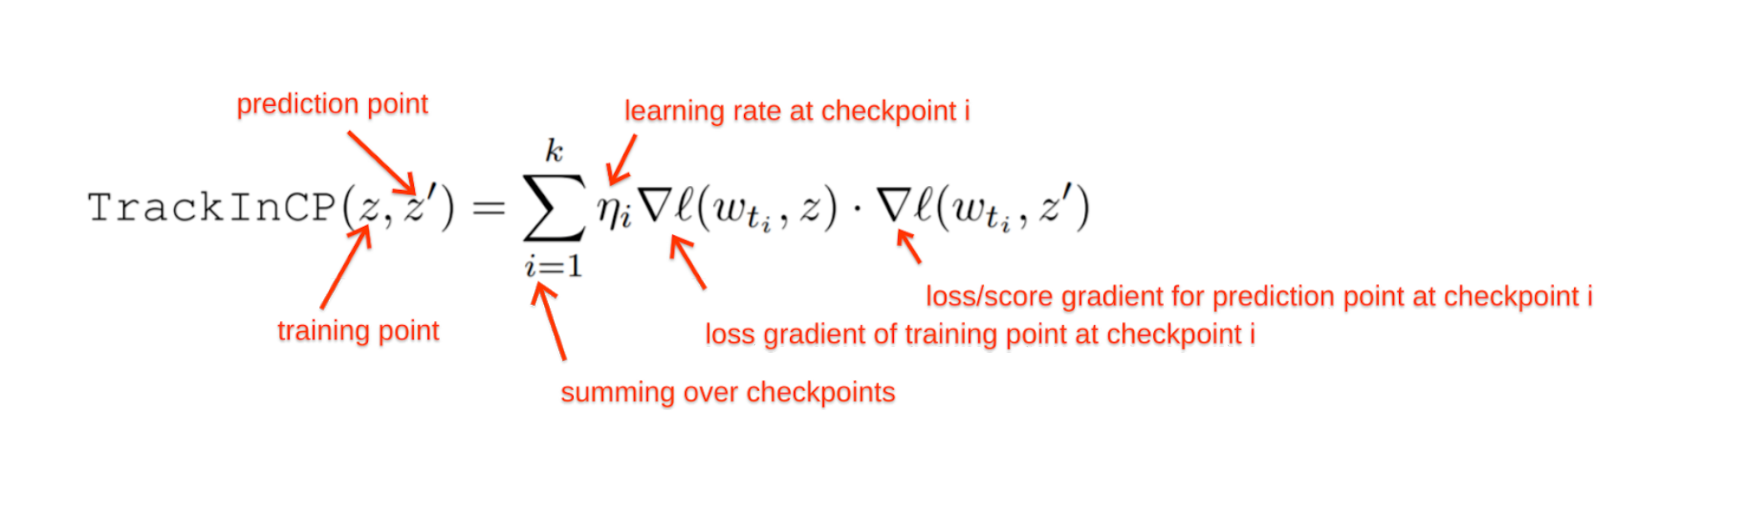

In [11]:
def calculate_tracin_score(model, weights, train_dataloader, test_dataloader, lr):

    # Store all the TracIn scores of a training point and a testing point in a matrix
    score_matrix = np.zeros((len(train_dataloader), len(test_dataloader)))

    for train_id, (x_train, y_train) in enumerate(train_dataloader):
        if train_id % 50 == 0:
            print('Train:', round(train_id / 500 * 100), '%')
        for test_id, (x_test, y_test) in enumerate(test_dataloader):
            grad_sum = 0

            # Iterating over the different checkpoints
            for w in weights:

                # Training point
                model = Net_c10()
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                y_pred = model(x_train) # pred
                loss = criterion(y_pred, y_train)
                loss.backward() # back
                train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])

                # Prediction (or testing) point
                model = Net_c10()
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                y_pred = model(x_test) # pred
                loss = criterion(y_pred, y_test)
                loss.backward() # back
                test_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])

                # TracInCP formula
                grad_sum += lr * np.dot(train_grad, test_grad)

            score_matrix[train_id][test_id] = grad_sum

    return score_matrix

In [12]:
# We will use subsets of train and test to save time
train_subset_c10 = torch.utils.data.Subset(trainset_c10, range(500))

test_subset_c10 =  torch.utils.data.Subset(testset_c10, range(50))

trainloader_sub_c10 = torch.utils.data.DataLoader(train_subset_c10, batch_size=1,
                                          shuffle=False)

testloader_sub_c10 = torch.utils.data.DataLoader(test_subset_c10, batch_size=1,
                                         shuffle=False)

In [13]:
tracin_matrix = calculate_tracin_score(model=Net_c10(),
                                       weights=weights_c,
                                       train_dataloader=trainloader_sub_c10,
                                       test_dataloader=testloader_sub_c10,
                                       lr=0.001)

Train: 0 %
Train: 10 %
Train: 20 %
Train: 30 %
Train: 40 %
Train: 50 %
Train: 60 %
Train: 70 %
Train: 80 %
Train: 90 %


In [14]:
def imshow_c10(imgs):
    fig = plt.figure(figsize=(8, 2))

    for i in range(3):
      imgs[i]  = (imgs[i] / 2 + 0.5)     # unnormalize
      imgs[i] = F.interpolate(imgs[i].unsqueeze(0), scale_factor=2, mode='bilinear', align_corners=False).squeeze(0).numpy()

    fig.add_subplot(1, 3, 1)
    plt.imshow(np.transpose(imgs[0], (1, 2, 0)))
    fig.add_subplot(1, 3, 2)
    plt.imshow(np.transpose(imgs[1], (1, 2, 0)))
    fig.add_subplot(1, 3, 3)
    plt.imshow(np.transpose(imgs[2], (1, 2, 0)))
    plt.show()

**Accuracy of the model**

In [15]:
correct = 0
total = 0
test_losses = []
with torch.no_grad():
    for data in testloader_c10:
        images, labels = data

        # Calculate outputs by running images through the network
        outputs = model_c(images)
        loss = criterion(outputs, labels)
        test_losses.append(loss)

        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


# **Results:** Proponents and Opponents


> 👍 Proponents : training examples that have a **positive**
value of influence score, i.e. they *reduce* the  loss of the test point.

---


> 👎 Opponents : training examples that have a **negative**
value of influence score, i.e. they *increase* the loss of the test point.

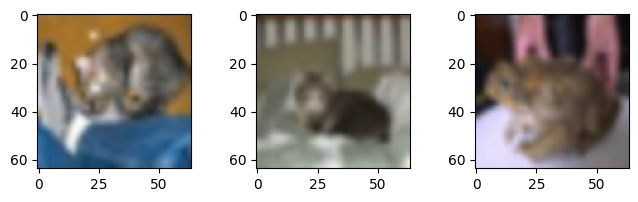

test example: cat 		 proponent: cat 		 opponent: frog


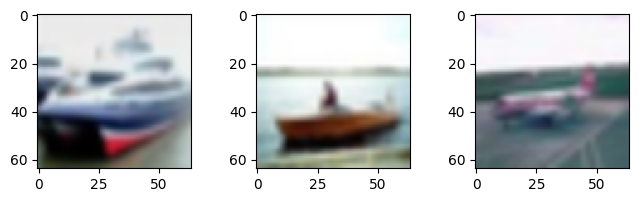

test example: ship 		 proponent: ship 		 opponent: plane


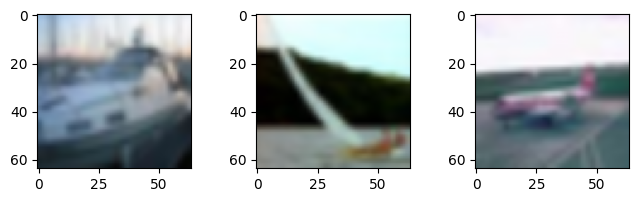

test example: ship 		 proponent: ship 		 opponent: plane


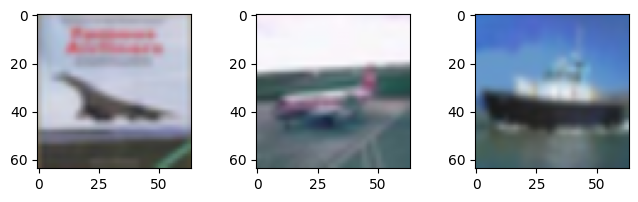

test example: plane 		 proponent: plane 		 opponent: ship


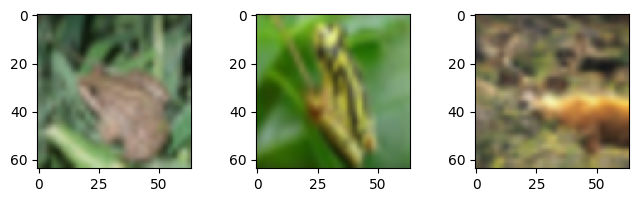

test example: frog 		 proponent: frog 		 opponent: deer


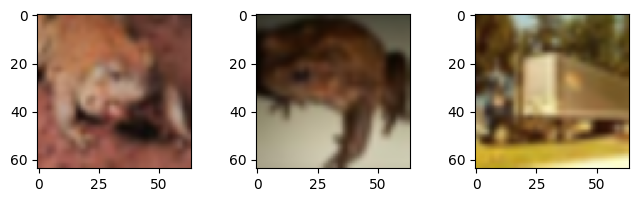

test example: frog 		 proponent: frog 		 opponent: truck


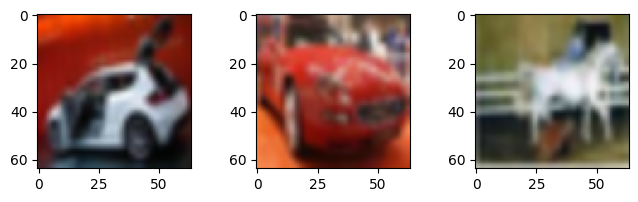

test example: car 		 proponent: car 		 opponent: horse


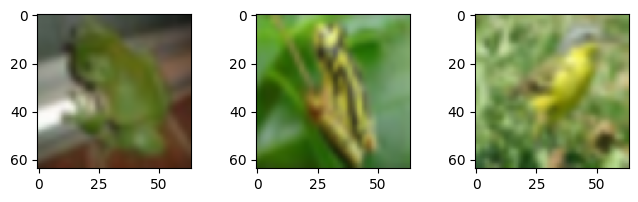

test example: frog 		 proponent: frog 		 opponent: bird


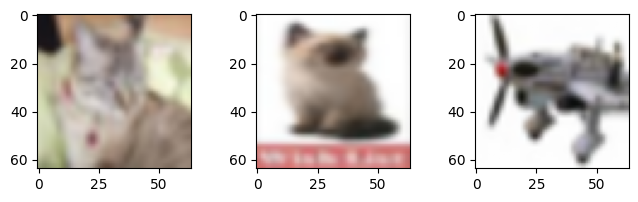

test example: cat 		 proponent: cat 		 opponent: plane


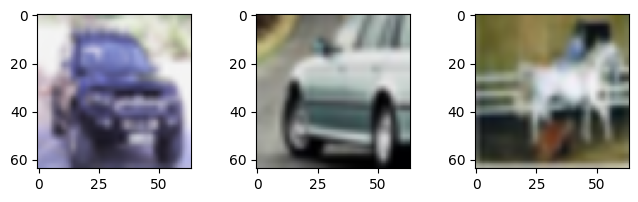

test example: car 		 proponent: car 		 opponent: horse


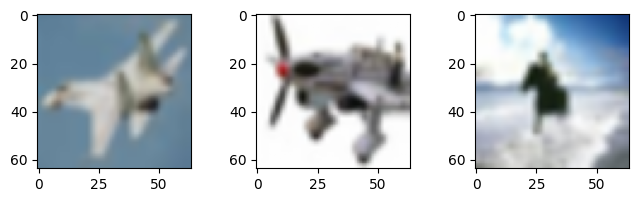

test example: plane 		 proponent: plane 		 opponent: horse


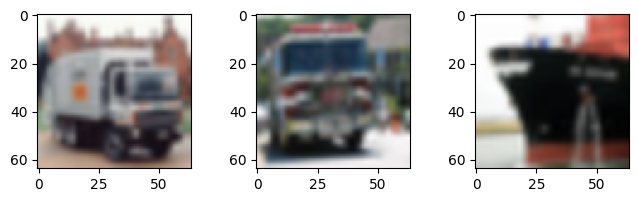

test example: truck 		 proponent: truck 		 opponent: ship


In [16]:
# Visualize the prediction image with its first proponent (the training point with the highest influence score)
# and first opponent (the training point with the smallest (negative) influence score)

for test_id, (x_test, y_test) in enumerate(testloader_sub_c10):
    col = tracin_matrix[:, test_id]

    # Find index of highest influence score along column corresponding to the prediction point of interest
    max_ind = col.argmax()

    # Find index of smallest influence score along column corresponding to the prediction point of interest
    min_ind = col.argmin()

    imshow_c10([test_subset_c10[test_id][0], train_subset_c10[max_ind][0], train_subset_c10[min_ind][0]])

    print('test example:', classes[test_subset_c10[test_id][1]], '\t\t', 'proponent:', classes[train_subset_c10[max_ind][1]], '\t\t', 'opponent:', classes[train_subset_c10[min_ind][1]])
    if test_id > 10:
      break

## **Evaluation**

# TracInCP (*equally weighted*)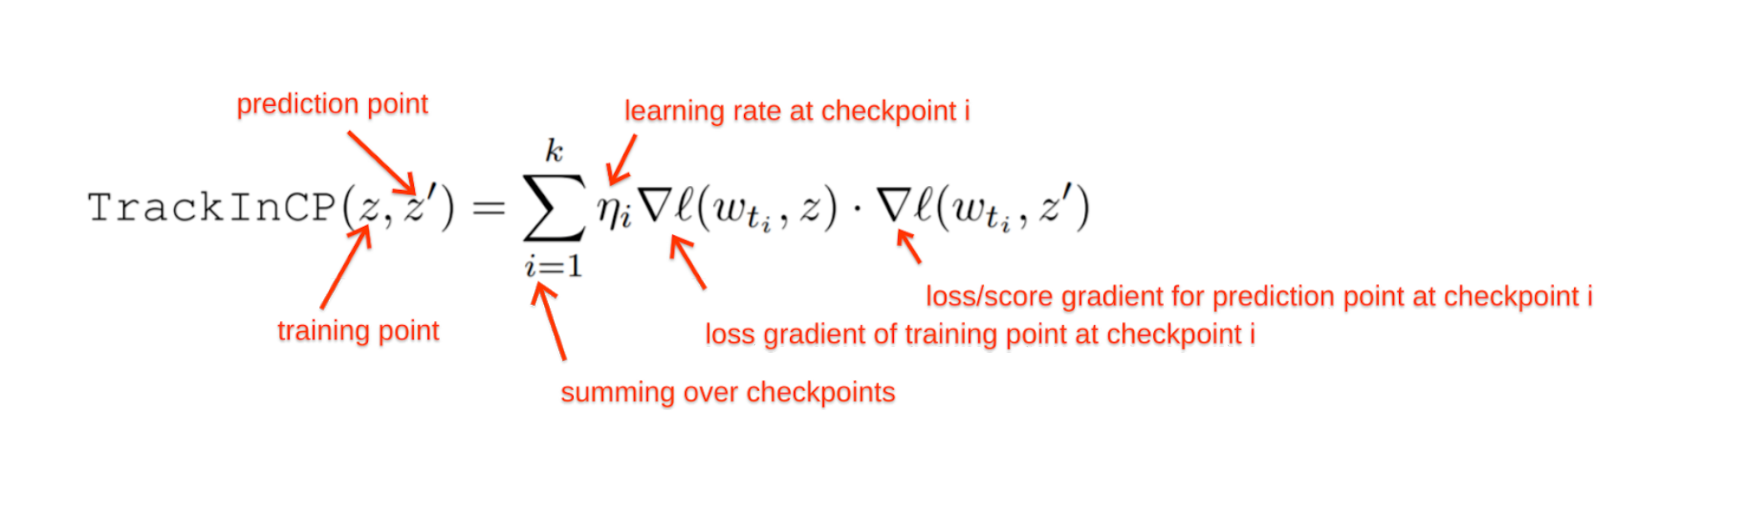

**Self-influence:** Now we want to look at the influence of a training point on its own loss (*prediction point and training point are the same*).

This is a way to *evaluate* and *compare* TracIn with other methods that measure influence in order to show its efficiency.

--> Indeed, based on the fact that incorrectly labelled examples are likely to be strong proponents for themselves, we will show how TracIn identifies these mislabelled points the **fastest**.

In [17]:
def calculate_self_influence_with_TracInCP(model, weights, train_dataloader, lr, variable_lr=False):

    LR = []
    if variable_lr:
        for i in range(len(weights)):
            LR.append(lr*(1/(i+1)))
    else:
        for i in range(len(weights)):
            LR.append(lr)
    print(f"learning rate: {LR}")

    score_matrix = np.zeros(len(train_dataloader))
    actual_and_predicted = np.zeros((len(train_dataloader), 2))

    for train_id, (x_train, y_train) in enumerate(train_dataloader):
            grad_sum = 0
            index_lr = 0

            for w in weights:
                model = Net_c10()
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                y_pred = model(x_train) # pred
                loss = criterion(y_pred, y_train)
                _, predicted = torch.max(y_pred.data, 1)
                loss.backward() # back
                train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])

                grad_sum += LR[index_lr] * np.dot(train_grad, train_grad) # scalar mult, TracIn formula
                index_lr += 1

            score_matrix[train_id] = grad_sum
            actual_and_predicted[train_id] = [y_train.detach().numpy()[0], predicted.detach().numpy()[0]]

    return score_matrix, actual_and_predicted

In [18]:
scores_tracin_eq, labels_tracin_eq = calculate_self_influence_with_TracInCP(model=Net_c10(),
                                                                            weights=weights_c,
                                                                            train_dataloader=trainloader_sub_c10,
                                                                            lr=0.001,
                                                                            variable_lr=False) # Same learning rate at every checkpoint

learning rate: [0.001, 0.001, 0.001]


As mentionned in the paper, incorrectly labelled examples are likely to be strong proponents for themselves. **This is shown in the cell below.**

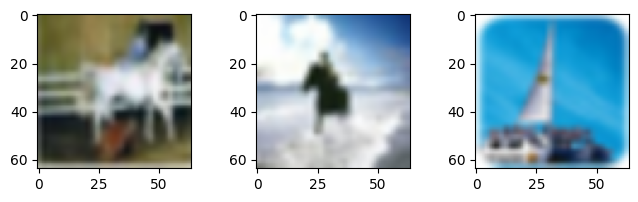

predicted label: car 		 predicted label: bird 		 predicted label: bird
actual label: horse 		 actual label: horse 		 actual label: ship


In [19]:
# Top 3 points with high self-influence scores

indices_of_top_10 = np.flip(sorted(range(len(scores_tracin_eq)), key=lambda i: scores_tracin_eq[i])[-10:])
res = []
for ind in indices_of_top_10:
  res.append(labels_tracin_eq[ind])
imshow_c10([train_subset_c10[indices_of_top_10[0]][0], train_subset_c10[indices_of_top_10[1]][0], train_subset_c10[indices_of_top_10[2]][0]])
print('predicted label:', classes[int(res[0][1])], '\t\t', 'predicted label:', classes[int(res[1][1])], '\t\t', 'predicted label:', classes[int(res[2][1])])
print('actual label:', classes[int(res[0][0])], '\t\t', 'actual label:', classes[int(res[1][0])], '\t\t', 'actual label:', classes[int(res[2][0])])

In [20]:
# Percentage of mislabelled points

mislab = 0
for pair in labels_tracin_eq:
  if pair[0] != pair[1]:
    mislab += 1

perct = (mislab*100)/len(labels_tracin_eq)

print("Percentage of mislabelled training points : ", perct)

Percentage of mislabelled training points :  31.6


Here we define a function that returns :

*   the fraction of training data that was checked,
*   the fraction of mislabelled data that was identified at that stage of the training.

In [21]:
def fraction_mislabelled_data(self_scores, label_matrix, perct):

    mislab = 0
    j = 0
    fraction_data = []
    fraction_mislab = []

    # We sort training examples by decreasing self-influence
    indices_decreasing = np.flip(sorted(range(len(self_scores)), key=lambda i: self_scores[i]))

    for i in indices_decreasing:
      j+=1

      # Mislabelled points
      if label_matrix[i][0] != label_matrix[i][1]:
        mislab += 1

      if j % 50 == 0: # i.e. 10% of training data (of length 500)

        # Franction of training data checked
        fraction_data.append(j/500)

        # Fraction of mislabelled data identified
        fraction_mislab.append(int(((mislab*10000)/(len(label_matrix)*perct))))

    return fraction_data, fraction_mislab

In [22]:
data_eq, mislab_eq = fraction_mislabelled_data(scores_tracin_eq, labels_tracin_eq, perct)

# TracInCP (*differently weighted*)

In [23]:
scores_tracin_diff, labels_tracin_diff = calculate_self_influence_with_TracInCP(model=Net_c10(),
                                                                                weights=weights_c,
                                                                                train_dataloader=trainloader_sub_c10,
                                                                                lr=0.001,
                                                                                variable_lr=True) # different learning rate values at each checkpoint

learning rate: [0.001, 0.0005, 0.0003333333333333333]


In [24]:
data_diff, mislab_diff = fraction_mislabelled_data(scores_tracin_diff, labels_tracin_diff, perct)

# Influence Functions

We want to compare TracIn firstly with **Influence Functions**, a method that uses *gradients* and *Hessian-vector products* to identify training points most responsible for a given prediction :


\begin{equation}
 \Large Inf(z, z^{'}) = -∇_wl(w, z^{'}) \cdot H_w^{-1} \cdot ∇_wl(w, z)
\end{equation}
with
\begin{equation}
 H_w = \sum_{i=1}^N ∇_w^2 l(w, z_i)
\end{equation}




In [25]:
def calculate_self_influence_with_inflfns(model, weights, train_dataloader, lr):

    score_matrix = np.zeros(len(train_dataloader))
    actual_and_predicted = np.zeros((len(train_dataloader), 2))

    # w correspond to the weights saved by the last checkpoint
    # because it is the one that results in the minimum loss amomg all the weights
    w = weights[-1]

    batch_size = 200
    sum_hess = torch.zeros((batch_size, batch_size))

    # sum (L(zi, w))
    for train_id, (x_train, y_train) in enumerate(train_dataloader):
      model = Net_c10()
      model.load_state_dict(torch.load(w))
      model.eval()
      y_pred = model(x_train)
      loss = criterion(y_pred, y_train)
      loss.backward() # back
      train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])

      # Since the number of parameters is very large (62006), computing the whole Hessian matrix and its inverse
      # is very expensive and requires a lot of space, hence we use the Pearlmutter trick to compute it more easily.
      grad_batch = train_grad[:batch_size]
      grad_batch_up = grad_batch.unsqueeze(0)
      sum_hess += grad_batch_up.t() * grad_batch_up

    for train_id_glob, (x_train_glob, y_train_glob) in enumerate(train_dataloader):

      model = Net_c10()
      model.load_state_dict(torch.load(w))
      model.eval()
      y_pred_final = model(x_train_glob)
      _, predicted = torch.max(y_pred_final.data, 1)
      final_loss = criterion(y_pred_final, y_train_glob)
      final_loss.backward() # back
      train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters()])
      grad_batch = train_grad[:batch_size]

      first = -grad_batch
      hessian = (1/batch_size) * sum_hess
      second = np.dot(np.linalg.inv(hessian), grad_batch)
      result = np.dot(first, second)

      score_matrix[train_id_glob] = result
      actual_and_predicted[train_id_glob] = [y_train_glob.detach().numpy()[0], predicted.detach().numpy()[0]]

    return score_matrix, actual_and_predicted

In [26]:
scores_inflfns, labels_inflfns = calculate_self_influence_with_inflfns(model=Net_c10,
                                                                      weights=weights_c,
                                                                      train_dataloader=trainloader_sub_c10,
                                                                      lr=0.001)

In [27]:
data_inflfns, mislab_inflfns = fraction_mislabelled_data(scores_inflfns, labels_inflfns, perct)

# Representer Point Method

Next, we compare TracIn with the **Representer Point Method**. This  second approach, grounded in the representer point theorem, involves breaking down the logits for a given test point as a weighted sum of dot products between the representation of the test point at the top layer of a neural network and the representations of the training points
--> **This is indeed a kernel method.**

The weights in this decomposition reflect the influences of the respective training points :


\begin{equation}
 \Large Rep(z, z^{'}) = -\frac{1}{2 \lambda n} (f(w_1, z) \cdot f(w_1, z^{'})) {\partial}_{\phi (w^{'}, z^{'})}l(w^{'}, z^{'})
\end{equation}

with
\begin{equation} f(w_1, z) \end{equation}
is the input representation, i.e. the outputs of the last hidden layer and
\begin{equation} \phi (w^{'}, z^{'}) \end{equation}
are the logits.

In [28]:
class Net_c10_repr(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 channels : RGB
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        fi = F.relu(self.fc2(x))#   fi = Φ2(xi, Θ2)
        out = self.fc3(fi)      #   Φ(xi, Θ) = Θ1*fi
        return out, fi

In [29]:
def calculate_self_influence_with_representer(model, weights, train_dataloader, lr):

    lam=0.01
    representer_score = np.zeros(len(train_dataloader))
    n = len(train_dataloader)
    actual_and_predicted = np.zeros((len(train_dataloader), 2))

    # Idem : last model, the best
    w = weights[-1]

    for train_id, (x_train, y_train) in enumerate(train_dataloader):

        model = Net_c10_repr()
        model.load_state_dict(torch.load(w))
        model.eval()
        y_pred, fi = model(x_train)                    # training point xt ---> logits, fi
        loss = criterion(y_pred, y_train)
        _, predicted = torch.max(y_pred.data, 1)

        #  αi = ∂L(xi,yi,Θ) / ( -2λn Φ(xt, Θ)); the minus of denominator is simplified with the minus of the gradient of the loss
        alpha = y_pred*loss / (2*lam*n*torch.sum(fi))

        # Representer Value = alpha * fi * ft
        repr_val = alpha * torch.sum(fi * fi) # ----> len = [10]

        # We select the representer value corresponding to the interested class (the real one)
        representer_score[train_id] = repr_val[0][y_train.detach().numpy()[0]]
        actual_and_predicted[train_id] = [y_train.detach().numpy()[0], predicted.detach().numpy()[0]]

    return representer_score, actual_and_predicted

In [30]:
scores_repr, labels_repr = calculate_self_influence_with_representer(model=Net_c10_repr(),
                                                                   weights=weights_c,
                                                                   train_dataloader=trainloader_sub_c10,
                                                                   lr=0.001)

In [31]:
data_repr, mislab_repr = fraction_mislabelled_data(scores_repr, labels_repr, perct)

# **Results:** Self Influence

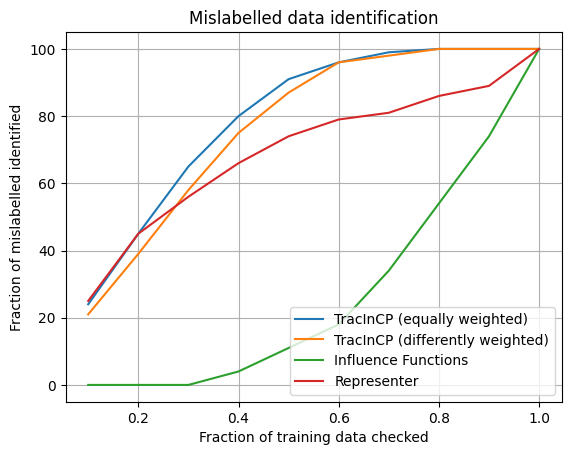

In [32]:
plt.plot(data_eq, mislab_eq, label='TracInCP (equally weighted)')
plt.plot(data_diff, mislab_diff, label='TracInCP (differently weighted)')
plt.plot(data_inflfns, mislab_inflfns, label='Influence Functions')
plt.plot(data_repr, mislab_repr, label="Representer")
plt.title('Mislabelled data identification')
plt.xlabel('Fraction of training data checked')
plt.ylabel('Fraction of mislabelled identified')
plt.legend()
plt.grid(True)
plt.show()